In [ ]:
# Imports
import babypandas as bpd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from ipywidgets import widgets
from IPython.display import clear_output, display

def standard_units(any_numbers):
    "Convert a sequence of numbers to standard units."
    return (any_numbers - any_numbers.mean()) / np.std(any_numbers)

# All of the following code is for visualization.
def plot_regression_line(df, x, y, margin=.02):
    '''Computes the slope and intercept of the regression line between columns x and y in df (in original units) and plots it.'''
    m = slope(df, x, y)
    b = intercept(df, x, y)
    
    df.plot(kind='scatter', x=x, y=y, s=100, figsize=(10, 5), label='original data')
    left = df.get(x).min()*(1 - margin)
    right = df.get(x).max()*(1 + margin)
    domain = np.linspace(left, right, 10)
    plt.plot(domain, m*domain + b, color='purple', label='regression line')
    plt.suptitle(format_equation(m, b), fontsize=18)
    plt.legend();
    
# Just for visual purposes
def format_equation(m, b):
    if b > 0:
        return r'$y = %.2fx + %.2f$' % (m, b)
    elif b == 0:
        return r'$y = %.2fx' % m
    else:
        return r'$y = %.2fx %.2f$' % (m, b)
    
# Don't worry about how this function works.
def plot_errors(df, m, b):
    x = df.get('x')
    y = m*x + b
    df.plot(kind='scatter', x='x', y='y', s=100, figsize=(10, 5), label='original data')
    plt.plot(x, y, color='purple', label='regression line')
    for k in np.arange(df.shape[0]):
        xk = df.get('x').iloc[k]
        yk = np.asarray(y)[k]
        if k == df.shape[0] - 1:
            plt.plot([xk, xk], [yk, df.get('y').iloc[k]], '--', c='r', linewidth=2, label='errors')
        else:
            plt.plot([xk, xk], [yk, df.get('y').iloc[k]], '--', c='r', linewidth=2)
    
    plt.suptitle(format_equation(m, b), fontsize=18)
    plt.xlim(50, 90)
    plt.ylim(40, 100)
    plt.legend();
    
def update_plot(w):
    m = slope_widget.value
    b = without_outlier.get('y').mean() - m * without_outlier.get('x').mean()
    with out:
        out.clear_output(wait=True)
        plot_errors(without_outlier, m, b)
        plt.show()

# Lecture 25 – Regression and Least Squares
## DSC 10, Winter 2022

### Announcements

- The Final Project is due on **Wednesday 3/9 at 11:59pm** ‼️
- Lab 8 is due on **Thursday 3/10 at 11:59pm**.
- The **Final Exam** is on **Saturday 3/12 from 3-6PM**.
    - Administered remotely via Gradescope in the same format as Midterm Exam (multiple choice, short answer, fill-in-the-blank code).
    - Work on the practice exams posted on the [Resources tab of the course website](https://dsc10.com/resources/) and come to office hours with any questions.
    - See [this post](https://campuswire.com/c/G6950E967/feed/1403) on Campuswire for more details.
- If at least 85% of the class fills out **both** [CAPEs](https://cape.usd.edu) and the [additional survey](https://forms.gle/pt9HZ4RJzBrz1Vz98), then everyone will receive an extra 0.5% added to their overall course grade.
- There will be just one discussion section today, from **6-7:30PM**. It will be entirely review. Come!
- Look at the [Calendar](https://dsc10.com/calendar/) for the updated office hours schedule.
    - Come to the in-person Study Jam on Wednesday from 3-7pm in the SDSC Auditorium!

### Agenda

- Prediction.
- The regression line.
- Outliers.
- Errors in prediction.

## Prediction

### Correlation

Recall, the correlation coefficient $r$ of two variables $x$ and $y$ is the 
- **average** value of the 
- **product** of $x$ and $y$
- when both are measured in **standard units**.

### The regression line

Suppose **$x$ and $y$ are in standard units**, and $r$ is the correlation coefficient between $x$ and $y$. Then, the regression line is defined as follows:

<center><img src='data/regression-line.png' width=400></center>

- The regression line is the line through $(0,0)$ with slope $r$.
- If $x$ and $y$ are linearly associated, then the graph of averages will be very similar to the regression line.
- If the regression line is given by $f(x) = mx + b$, then the prediction for $x$ is given by $f(x)$.

### Discussion Question

A course has a midterm (mean 80, standard deviation 15) and a really hard final (mean 50, standard deviation 12).

If the scatter diagram comparing midterm & final scores for students looks linearly associated with correlation 0.75, then what is the predicted final exam score for a student who received a 90 on the midterm?

- A. 54
- B. 56
- C. 58
- D. 60
- E. 62

### To answer, go to [menti.com](https://menti.com) and enter the code 1728 4068.

## The regression line

### The regression line in standard units

When $x$ and $y$ are in standard units, the regression line is given by

$$y_{\text{su}} = r \cdot x_{\text{su}}$$

What is the regression line when $x$ and $y$ are in their original units?

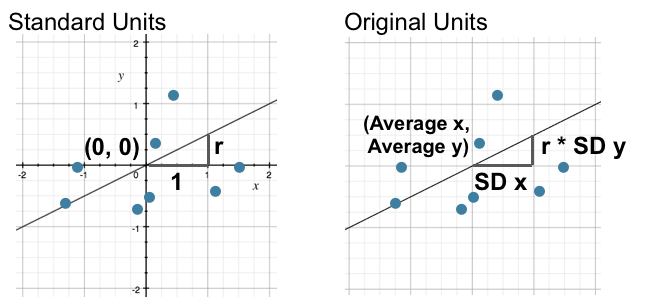

### The regression line in original units

- We can work backwards from the relationship $y_{\text{su}} = r \cdot x_{\text{su}}$ to find the line in original units.

$$y_{\text{su}} = r \cdot x_{\text{su}}$$

$$\frac{y - \text{mean of }y}{\text{SD of }y} = r \cdot \frac{x - \text{mean of } x}{\text{SD of }x}$$

- Note that $\text{mean of } x$, $\text{mean of } y$, $\text{SD of } x$, and $\text{SD of } y$ are constants.
- Re-arranging the above equation into the form $y = mx + b$ yields the formulas

$$m = r \cdot \frac{\text{SD of } y}{\text{SD of }x}, \: \: b = \text{mean of } y - m \cdot \text{mean of } x$$

- $m$ is the slope of the regression line and $b$ is the intercept.

Let's implement these formulas in code and try them out.

In [ ]:
def correlation(df, x, y):
    '''Computes the correlation between column x and column y of df.'''
    return (standard_units(df.get(x)) * standard_units(df.get(y))).mean()

def slope(df, x, y):
    '''Returns the slope of the regression line between columns x and y in df (in original units).'''
    r = correlation(df, x, y)
    return r * np.std(df.get(y)) / np.std(df.get(x))

def intercept(df, x, y):
    '''Returns the intercept of the regression line between columns x and y in df (in original units).'''
    return df.get(y).mean() - slope(df, x, y) * df.get(x).mean()

### Example: heights

In [ ]:
galton = bpd.read_csv('data/galton.csv')
galton

In [ ]:
m_heights = slope(galton, 'midparentHeight', 'childHeight')
m_heights

In [ ]:
b_heights = intercept(galton, 'midparentHeight', 'childHeight')
b_heights

### Making predictions

In [ ]:
def predict_child_height(midparent):
    return m_heights * midparent + b_heights

What's the predicted height of a child whose midparent height is 62 inches?

In [ ]:
predict_child_height(62)

What about for a child whose midparent height is 55 inches? 73 inches?

In [ ]:
predict_child_height(55)

In [ ]:
predict_child_height(73)

## Outliers

### The effect of outliers on correlation

Consider the dataset below. What is the correlation between $x$ and $y$?

In [ ]:
outlier = bpd.read_csv('data/outlier.csv')
outlier.plot(kind='scatter', x='x', y='y', s=100, figsize=(10, 5));

In [ ]:
correlation(outlier, 'x', 'y')

In [ ]:
plot_regression_line(outlier, 'x', 'y')

### Removing the outlier

In [ ]:
without_outlier = outlier[outlier.get('y') > 40]

In [ ]:
correlation(without_outlier, 'x', 'y')

In [ ]:
plot_regression_line(without_outlier, 'x', 'y')

**Takeaway:** Even a single outlier can have a massive impact on the correlation, and hence the regression line. Look for these before performing regression.

## Errors in prediction

### Errors in prediction

- We stated that the regression line in standard units is $y_{\text{su}} = r \cdot x_{\text{su}}$, and used that to find a formula for the regression line in original units.
- The regression lines we've seen so far seem like they fit our data well, but how well? What makes them good?

### Without the outlier

In [ ]:
m_no_outlier = slope(without_outlier, 'x', 'y')
b_no_outlier = intercept(without_outlier, 'x', 'y')

m_no_outlier, b_no_outlier

In [ ]:
plot_errors(without_outlier, m_no_outlier, b_no_outlier)

### Measuring the error in prediction

$$\text{error} = \text{actual value} - \text{prediction}$$

- Typically, some errors are positive and some negative.
    - What does a positive error mean? What about a negative error?

- To measure the rough size of the errors:
    1. Square the errors so that they don't cancel each other out.
    2. Take the mean of the squared errors.
    3. Take the square root to fix the units.
    
- This is called **root mean square error** (RMSE).

### Root mean squared error (RMSE)

In [ ]:
predictions = without_outlier.assign(pred=m_no_outlier * without_outlier.get('x') + b_no_outlier)
predictions = predictions.assign(diffs=predictions.get('y') - predictions.get('pred'))
predictions = predictions.assign(sq_diffs=predictions.get('diffs') ** 2)
predictions

In [ ]:
np.sqrt(predictions.get('sq_diffs').mean())

### Root mean squared error (RMSE)

In [ ]:
def rmse(true, pred):
    '''Calculates the RMSE for two sequences:
    true: the true values of the predicted attribute (i.e. y)
    pred: the predicted values
    '''
    return np.sqrt(((true - pred) ** 2).mean())

In [ ]:
rmse(predictions.get('y'), m_no_outlier * predictions.get('x') + b_no_outlier)

### How good are the predictions made by a given line?

- We're using the regression line to make predictions. But could we use a different line?
- How do we compare different lines used for prediction?
    - Low RMSE = better fit to the data.
- The best line is the one with the lowest RMSE.
- Let's try to find this best line.

In [ ]:
out = widgets.Output(layout=widgets.Layout(height='400px', width='800px'))
slope_widget = widgets.FloatSlider(min=m_no_outlier-5, max=m_no_outlier+5, step=0.2, value=m_no_outlier)
update_plot([])
slope_widget.observe(update_plot)
display(slope_widget, out)

### Finding the best line

Here's one approach:

1. Look at a large number of possible lines (i.e. pairs of slopes/intercepts).
2. Calculate the RMSE of each line.
3. Take the slope/intercept pair with the smallest RMSE.

This may take a while to run!

In [ ]:
errors = np.array([])
slopes = np.array([])
intercepts = np.array([])

# For many different slopes:
for m in np.arange(-1, 1, 0.01):
    # For many different intercepts:
    for b in np.arange(-50, 50, 0.5):
        # Compute the RMSE of a line with a given slope and intercept
        pred = m * without_outlier.get('x') + b
        error = rmse(pred, without_outlier.get('y'))

        # Store that RMSE in an array
        errors = np.append(errors, error)
        slopes = np.append(slopes, m)
        intercepts = np.append(intercepts, b)

What's the lowest RMSE we saw?

In [ ]:
errors.min()

Which slope/intercept pair had the lowest RMSE?

In [ ]:
# Find the slope corresponding to the smallest error. Don't worry about the code.
m_smallest_rmse = slopes[errors.argmin()]
m_smallest_rmse

In [ ]:
# Find the intercept corresponding to the smallest error. Don't worry about the code.
b_smallest_rmse = intercepts[errors.argmin()]
b_smallest_rmse

### Coincidence?

In [ ]:
# The slope and intercept with the smallest RMSE
m_smallest_rmse, b_smallest_rmse

In [ ]:
# The slope and intercept according to our regression line formulas
slope(without_outlier, 'x', 'y'), intercept(without_outlier, 'x', 'y')

The slopes and intercepts we got using both approaches look pretty similar... 👀

### The regression line

- It turns out that the regression line we defined before before minimizes the root mean squared error (RMSE) among all lines.

$$m = r \cdot \frac{\text{SD of } y}{\text{SD of }x}$$

$$b = \text{mean of } y - m \cdot \text{mean of } x$$
  
- It is the **best** line, regardless of what our data looks like!
- All equivalent names:
    - Line of “best fit”.
    - Least squares line.
    - Regression line.
- The technique of finding the slope and intercept that have the lowest RMSE is called the **method of least squares**.

### Quality of fit

- The regression line describes the "best linear fit" for a given dataset.
- The formulas for the slope and intercept work no matter what the shape of the data is.
- But the line is only meaningful if the relationship between $x$ and $y$ is roughly linear.

### Example: non-linear data

What's the regression line for this dataset?

In [ ]:
np.random.seed(23)
x2 = bpd.DataFrame().assign(
    x=np.arange(-6, 6.1, 0.5) + np.random.normal(size=25), 
    y=np.arange(-6, 6.1, 0.5)**2 + np.random.normal(size=25)
)
x2.plot(kind='scatter', x='x', y='y', s=100, figsize=(10, 5));

In [ ]:
plot_regression_line(x2, 'x', 'y')

Would it be a good idea to use this line to predict a $y$ given an $x$?

## Summary

### Summary, next time

- The regression line in original units is

$$m = r \cdot \frac{\text{SD of } y}{\text{SD of }x}$$

$$b = \text{mean of } y - m \cdot \text{mean of } x$$
- This line is very sensitive to outliers.
- This line has the lowest root mean squared error (RMSE) of all possible lines.
    - It is the "line of best fit".
- **Next time:** Review.